# 2. Modeling

## 2.1 투자성향 예측모델

In [ ]:
cus_info['lowsell_total'] = cus_info['lowsell_kr'] + cus_info['lowsell_oss']
cus_info['highsell_total'] = cus_info['highsell_kr'] + cus_info['highsell_oss']
cus_info['lowbuy_total'] = cus_info['lowbuy_kr'] + cus_info['lowbuy_oss']
cus_info['highbuy_total'] = cus_info['highbuy_kr'] + cus_info['highbuy_oss']
cus_info['net_purchase_total'] = cus_info['net_purchase_kr'] + cus_info['net_purchase_oss']

In [ ]:
#코로나 이전 이후 그룹 나누기

df = pd.merge(kr,oss,on=['cus_id','orr_dt'],how='outer')
df = df.groupby(by=['cus_id']).min()

from datetime import datetime
df1 = df.loc[df['orr_dt']<datetime(2020, 1, 1)].reset_index()
df2 = df.loc[df['orr_dt']>datetime(2020, 1, 1)].reset_index()

df1['covid']='before'
df2['covid']='after'

df1 = df1[['cus_id','covid']]
df2 = df2[['cus_id','covid']]

df = pd.merge(df1,df2,on=['cus_id','covid'],how='outer')
cus_info = pd.merge(cus_info,df,on=['cus_id'],how='outer')

해외와 한국의 케이스를 모두 포괄할 수 있는 **_total** 변수를 만듭니다

In [ ]:
cus_info_test = cus_info.loc[(cus_info['ivst'] == '등급없음') | (cus_info['ivst'] == '정보 제공 미동의')]
cus_info_1 = cus_info.loc[(cus_info['ivst'] != '등급없음') & (cus_info['ivst'] != '정보 제공 미동의')]

정보가 제공되지 않은 데이터를 테스트 셋으로 설정합니다. 정보가 제공된 데이터를 이용하여 적절한 예측모델을 적합한다면 이들의 등급을 예측할 수 있습니다.

In [ ]:
target = []

for i in cus_info_1['ivst']:
    if i == '안정형':
        target.append(0)
    elif i == '안정추구형':
        target.append(0)
    elif i == '위험중립형':
        target.append(1)
    elif i == '공격투자형':
        target.append(2)
    elif i == '적극투자형':
        target.append(2)
    else:
        target.append(3)
        
cus_info_1['target'] = target

투자성향을 크게 세 부류로 나누고(안정/중립/위험), 예측의 대상이 되는 타깃변수로 지정하였습니다.

In [ ]:
cus_info_2 = cus_info_1.dropna(axis=0)
cus_info_nan = cus_info_1[cus_info_1['covid'].isnull()]

In [ ]:
covidd = []

for i in cus_info_2['covid']:
    if i == 'after':
        covidd.append(1)
    else:
        covidd.append(0)

cus_info_2['covid'] = covidd

'covid'변수는 이항변수인 만큼 그 결측치를 대체하기가 쉽지 않아 결측치가 존재하는 행을 제외하였습니다.
'covid'변수가 0/1의 값 중 하나를 취하도록 변환하였습니다

In [ ]:
cus_info_df = cus_info_2[['age_cat', 'sex', 'grade', 'num_act', 'covid', 'lowsell_total',
                          'highsell_total', 'lowbuy_total', 'highbuy_total', 'net_purchase_total']]

cus_info_target = cus_info_2['target']

cus_info_df를 설명변수, cus_info_target을 관심변수로 설정합니다

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cus_info_df[['lowsell_total', 'highsell_total', 'lowbuy_total', 'highbuy_total', 'net_purchase_total']] = scaler.fit_transform(cus_info_df[['lowsell_total', 'highsell_total', 'lowbuy_total',
                                              'highbuy_total', 'net_purchase_total']])

정규화를 거치지 않을 경우 단위 등에 의해 매우 큰 값을 가지게 되는 수치형 변수가 예측에 막대한 영향을 끼치게 됩니다. 이를 방지하고자 MinMaxScaler를 적용하여 데이터를 정규화하였습니다.

In [ ]:
gradee = []

for i in cus_info_df['grade']:
    if i == '등급없음':
        gradee.append(0)
        
    elif i == '블루':
        gradee.append(1)
        
    elif i == '그린':
        gradee.append(2)
    
    elif i == '로얄':
        gradee.append(3)
    
    elif i == '골드':
        gradee.append(4)
        
    elif i == '탑클래스':
        gradee.append(5)

cus_info_df['grade'] = gradee

'grade'변수를 머신러닝 모델이 인식할 수 있는 형태로 전환하였습니다. 'grade'변수는 순서형 변수이므로 추후에 사용될 pd.get_dummies를 사용하지 않았습니다. pd.get_dummies는 범주형 변수를 수치형 가변수로 전환합니다.

In [ ]:
cus_info_df = pd.get_dummies(cus_info_df)

나이대를 표현하는 'age_cat'변수는 값들 사이의 관계성이 없기 때문에 pd.get_dummies를 사용하여 가변수로 전환합니다.

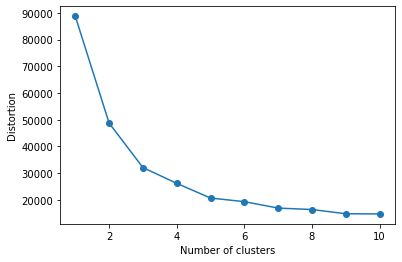

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []

for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cus_info_df)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

 비지도학습의 일종인 K-평균 방식을 사용하였습니다. 비지도학습의 경우 예측의 대상이되는 타깃 변수를 사용하지 않고, 설명변수들 만을 사용하여 주어진 데이터를 k개의 군집으로 분류합니다. 적절한 k를 구하고자 k의 변동에 따른 오류의 변화를 그래프로 나타냈습니다. k가 5이상인 경우부터는 오류가 유의미하게 감소되지 않으므로 적절한 군집의 개수 k는 4입니다. 실제로 타깃변수가 크게 4가지로 분류되는 것을 고려하면 합리적인 결과입니다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(cus_info_df, cus_info_target,
                                                       test_size=0.2,  random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4346, 16) (1087, 16) (4346,) (1087,)


모델의 학습을 위해 주어진 데이터를 분할합니다

In [ ]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error

lgb_dtrain = lgb.Dataset(data=X_train, label=y_train)
lgb_param = {'max_depth' : 10,
             'learning_rate' : 0.81,
             'n_estimators' : 400,
             'objective' : 'regression'}

lgb_model = lgb.train(params=lgb_param, train_set=lgb_dtrain)
lgb_model_predict = lgb_model.predict(X_test)

print('RMSE : {}'.format(sqrt(mean_squared_error(lgb_model_predict, y_test))))

RMSE : 0.9500054322190713


지도학습 분류모델 중 가장 유용하게 쓰이는 알고리즘인 lightgbm을 적용시켰습니다.

In [ ]:
import shap
import skimage

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

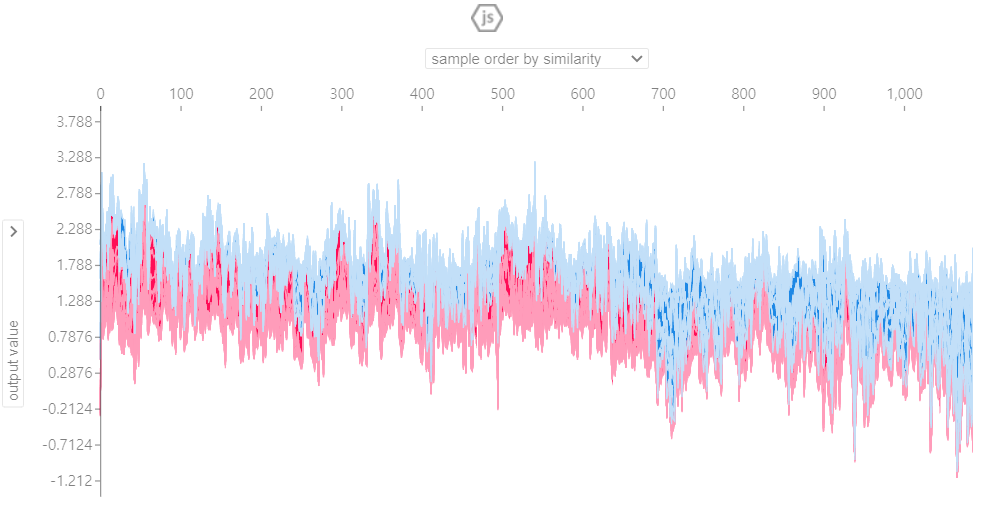

In [ ]:
from IPython.display import Image

Image('0.png')

force_plot은 개별 모델의 예측을 시각화하는 plot으로 각 데이터별 변수들의 영향도를 볼 수 있습니다.
빨간색이 영향도가 높으며, 파란색이 영향도가 낮습니다.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0, :])

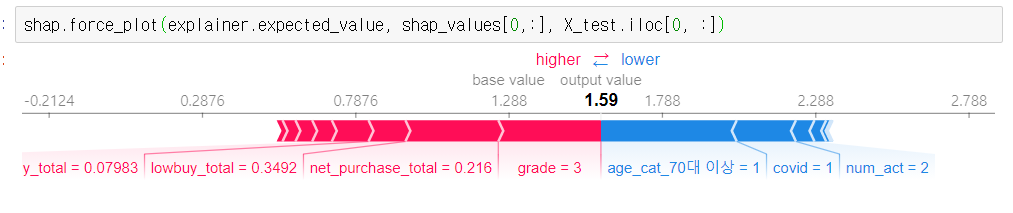

In [ ]:
Image('1.png')

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1, :])

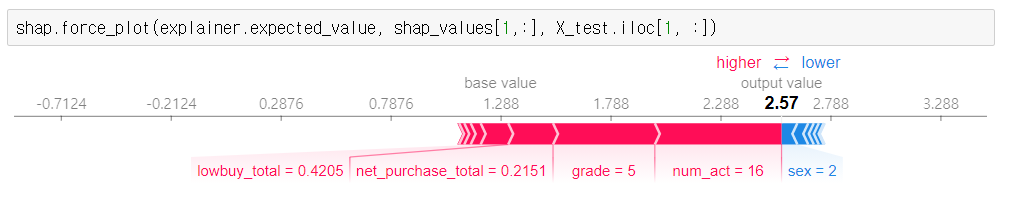

In [ ]:
Image('2.png')

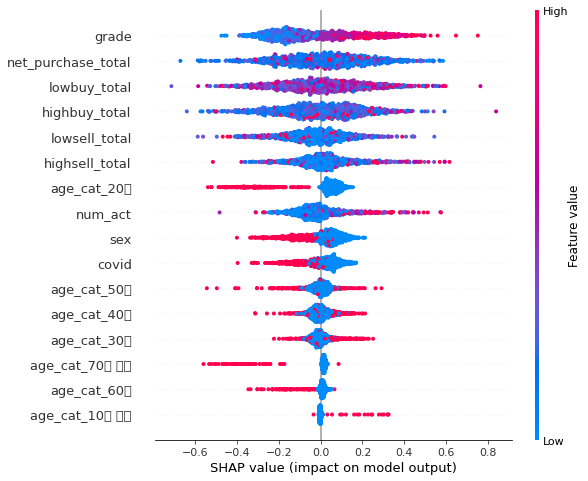

In [ ]:
shap.summary_plot(shap_values, X_test)

보다 직관적인 이해를 위해 summary plot을 사용할 수 있습니다.     
자산 규모가 커질수록 투자성향은 공격적이게 됩니다.     
또한 코로나 이후 진입했을 때 투자성향이 안정적일 확률이 더 높습니다.     
성별의 경우도 여자가 더 안정적인 성향을 띄게됩니다. 

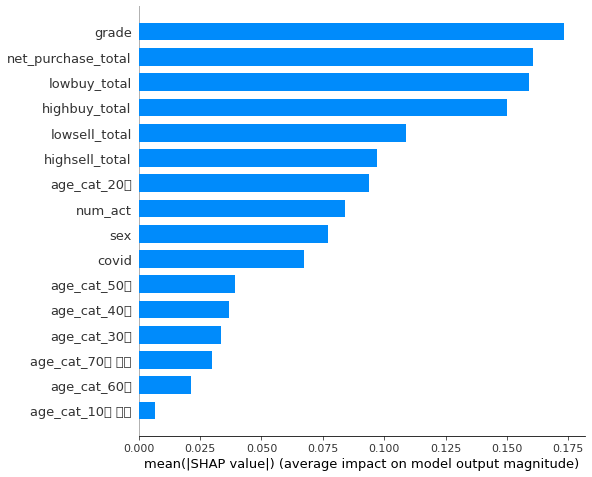

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

summary_plot을 막대 그래프 형식으로 나타냈습니다.    
위 그래프는 여러 트리모델에서 사용할 수 있는 feature_importance와 같은 기능을 한다고 볼 수 있습니다.     
각 변수에 대한 shap value의 절대값으로 각 변수들의 중요도를 파악할 수 있습니다.

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ll = Lasso(alpha=0.01)
ll.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

각 변수들의 중요도를 파악하기 위해 일종의 변수 선택 기능을 하는 라쏘 회귀를 적용시켰습니다.   
라쏘 회귀는 설명변수의 개수가 증가하는 것에 페널티를 부여하여, 유의하지 않은 개별 변수들의 영향력을 0으로 축소합니다.

In [ ]:
ll.coef_

array([-0.11439215,  0.13143029,  0.01478192, -0.07840506, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.31791311,  0.03943511,  0.04796841,  0.        , -0.        ,
       -0.11401581])

학습이 완료된 라쏘 회귀모델의 계수들 중 일부가 0의 값을 갖는 것을 확인할 수 있습니다.

In [ ]:
var_coef = pd.DataFrame({'variables': cus_info_df.columns,
              'coefs': ll.coef_}).sort_values(by='coefs',
                                              ascending=False)
var_coef

,variables,coefs
1,grade,0.13
12,age_cat_40대,0.05
11,age_cat_30대,0.04
2,num_act,0.01
4,lowsell_total,-0.00
5,highsell_total,-0.00
6,lowbuy_total,-0.00
7,highbuy_total,0.00
8,net_purchase_total,0.00
9,age_cat_10대 미만,0.00


앞서 다뤘던 lgbm과 다른 점도 있지만 공통적으로 자산규모, 코로나 전후, 성별 변수가 유의한 것을 확인 할 수 있습니다

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

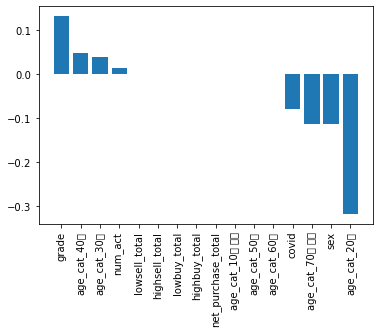

In [ ]:
plt.bar(var_coef['variables'], var_coef['coefs'])
plt.xticks(rotation=90)